In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, multilabel_confusion_matrix
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection import GridSearchCV
from splitrepeat import splitrepeat_cv

config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

features=['moca_digits','moca_letters','moca_serial7','MMSPELL_early','MMSPELL_late','ADAS_Q1','moca_orient','ADAS_Q7','ADAS_Q8','ADAS_Q9','MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR','MMCITY', 'MMAREA', 'MMSTATE','nbspan_forward',
       'faq7','faq8','moca_recall','ADAS_Q4','MMBALLDL', 'MMFLAGDL', 'MMTREEDL', 'LDELTOTAL', 'AVRECALL', 'AVDEL30MIN', 'AVDELTOT', 'AVDELERR2',
       'faq9','moca_clock','MMDRAW','CLOCKCIRC', 'CLOCKSYM','CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME', 'tmab_time', 'TRAAERRCOM','TRAAERROM', 'TRABERRCOM', 'TRABERROM','moca_naming','moca_repeat','moca_fluency',
       'moca_similarities','ADAS_Q2', 'ADAS_Q5','ADAS_Q10','ADAS_Q11','ADAS_Q12','MMBALL', 'MMFLAG', 'MMTREE',
       'MMWATCH', 'MMPENCIL','MMREPEAT','MMREAD', 'MMWRITE', 'CATANIMSC', 'CATVEGESC', 'moca_visuo_exec','ADAS_Q3','ADAS_Q6','ADAS_Q13','MMHAND', 'MMFOLD',
       'MMONFLR','nbspan_backward','faq1','faq2','faq3', 'faq4','faq5','faq6','faq10','PXGENAPP', 'PXHEADEY', 'PXNECK', 'PXCHEST',
       'PXHEART', 'PXABDOM', 'PXEXTREM', 'PXPERIPH', 'PXSKIN', 'PXMUSCUL', 'e_memory_pt', 'e_lang_pt', 'e_visspat_pt', 'e_plan_pt', 'e_organ_pt',
       'e_divatt_pt','e_memory_cg', 'e_lang_cg', 'e_visspat_cg','e_plan_cg', 'e_organ_cg', 'e_divatt_cg']


categorical_features = np.in1d(features, ['MMONFLR', 'faq10', 'faq6', 'COPYSYM', 'COPYNUM', 'faq5', 'MMTREE', 'COPYHAND', 'moca_clock', 'MMSEASON', 'moca_letters', 
                                          'MMBALL', 'faq9', 'MMFLOOR', 'MMDRAW', 'MMMONTH', 'PXGENAPP', 'MMWATCH', 'CLOCKCIRC', 'faq8', 'MMHOSPIT', 'moca_naming', 
                                          'PXEXTREM', 'CLOCKNUM', 'PXMUSCUL', 'faq1', 'MMTREEDL', 'CLOCKTIME', 'PXABDOM', 'MMFLAG', 'COPYCIRC', 'MMAREA', 'faq3', 
                                          'moca_digits', 'CLOCKHAND', 'MMREAD', 'MMYEAR', 'MMREPEAT', 'moca_visuo_exec','MMHAND', 'MMBALLDL', 'PXCHEST', 'MMDATE', 
                                          'MMFLAGDL',  'MMSTATE','moca_repeat', 'MMFOLD', 'MMPENCIL', 'MMDAY',  'faq2', 'PXHEART', 'CLOCKSYM', 'faq4', 'moca_serial7', 
                                          'faq7', 'MMCITY', 'PXHEADEY', 'COPYTIME', 'PXPERIPH', 'PXSKIN', 'moca_fluency', 'moca_similarities', 'PXNECK', 'MMWRITE',
                                          'e_memory_pt', 'e_lang_pt', 'e_visspat_pt', 'e_plan_pt', 'e_organ_pt', 'e_divatt_pt','e_memory_cg', 'e_lang_cg', 
                                          'e_visspat_cg','e_plan_cg', 'e_organ_cg', 'e_divatt_cg'])

data = pd.read_csv('../data/interim/data_adni.csv')
X = data[features]
y = data['CDGLOBAL']

In [2]:
X, X_test, y, y_test = train_test_split(X, y, train_size=0.25, random_state=33433, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=33433, stratify=y)     

# All - Feature Selection

In [3]:
from sklearn.ensemble import GradientBoostingClassifier 
rf = RandomForestClassifier(n_estimators=700, max_features=.3, max_depth = 20, min_samples_split = 10, min_samples_leaf = 1, bootstrap=True, random_state=33433)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features=0.3,
                       min_samples_leaf=4, min_samples_split=4,
                       n_estimators=1400, random_state=33433)

## BorutaSHAP

In [4]:
from BorutaShap import BorutaShap

bshap = BorutaShap(model=rf, importance_measure='shap', classification=True)

In [5]:
bshap.fit(X, y, random_state=33433, n_trials=200)

100%|██████████████████████████████████████| 200/200 [1:58:18<00:00, 35.49s/it]

17 attributes confirmed important: ['e_lang_pt', 'faq2', 'ADAS_Q1', 'LDELTOTAL', 'faq3', 'ADAS_Q4', 'tmab_time', 'faq9', 'e_divatt_cg', 'ADAS_Q8', 'faq7', 'e_lang_cg', 'ADAS_Q7', 'faq10', 'e_memory_pt', 'CATANIMSC', 'e_memory_cg']
88 attributes confirmed unimportant: ['ADAS_Q3', 'PXNECK', 'MMSPELL_late', 'ADAS_Q11', 'e_visspat_cg', 'moca_clock', 'moca_orient', 'COPYTIME', 'PXMUSCUL', 'COPYCIRC', 'ADAS_Q10', 'moca_letters', 'MMDRAW', 'PXEXTREM', 'AVDEL30MIN', 'MMSTATE', 'PXHEADEY', 'ADAS_Q6', 'AVDELERR2', 'ADAS_Q9', 'TRABERROM', 'moca_digits', 'MMDATE', 'AVDELTOT', 'CLOCKCIRC', 'MMMONTH', 'faq6', 'faq8', 'moca_visuo_exec', 'PXABDOM', 'e_divatt_pt', 'faq5', 'COPYSYM', 'CLOCKHAND', 'MMHAND', 'MMYEAR', 'MMBALLDL', 'e_organ_cg', 'TRAAERROM', 'faq1', 'moca_naming', 'MMHOSPIT', 'COPYNUM', 'ADAS_Q12', 'MMTREE', 'MMFOLD', 'MMAREA', 'CLOCKTIME', 'MMFLOOR', 'TRABERRCOM', 'TRAAERRCOM', 'faq4', 'PXHEART', 'PXGENAPP', 'MMFLAGDL', 'moca_similarities', 'PXPERIPH', 'MMWRITE', 'MMWATCH', 'e_organ_pt', '

In [5]:
bshap.fit(X, y)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [12:21<00:00, 37.07s/it]

14 attributes confirmed important: ['e_divatt_cg', 'LDELTOTAL', 'faq9', 'e_memory_pt', 'ADAS_Q8', 'faq2', 'ADAS_Q7', 'faq10', 'tmab_time', 'faq3', 'e_memory_cg', 'e_lang_cg', 'ADAS_Q1', 'ADAS_Q4']
86 attributes confirmed unimportant: ['PXABDOM', 'AVDELERR2', 'ADAS_Q2', 'PXPERIPH', 'moca_orient', 'AVRECALL', 'e_organ_pt', 'MMWRITE', 'COPYTIME', 'MMREPEAT', 'MMONFLR', 'COPYNUM', 'MMFLOOR', 'moca_repeat', 'e_divatt_pt', 'ADAS_Q9', 'faq4', 'CLOCKCIRC', 'moca_similarities', 'MMBALLDL', 'PXEXTREM', 'CLOCKHAND', 'MMSPELL_late', 'faq1', 'e_visspat_cg', 'moca_recall', 'MMDRAW', 'MMWATCH', 'CLOCKTIME', 'MMAREA', 'MMSPELL_early', 'PXMUSCUL', 'e_plan_cg', 'MMBALL', 'TRAAERROM', 'MMDAY', 'MMFLAG', 'ADAS_Q3', 'ADAS_Q10', 'MMYEAR', 'PXCHEST', 'PXHEADEY', 'PXHEART', 'COPYHAND', 'ADAS_Q13', 'MMPENCIL', 'MMHOSPIT', 'faq8', 'COPYCIRC', 'MMMONTH', 'MMFOLD', 'MMDATE', 'moca_visuo_exec', 'PXNECK', 'nbspan_backward', 'ADAS_Q12', 'moca_letters', 'faq6', 'MMTREE', 'faq5', 'moca_naming', 'MMREAD', 'MMSTATE', 'T

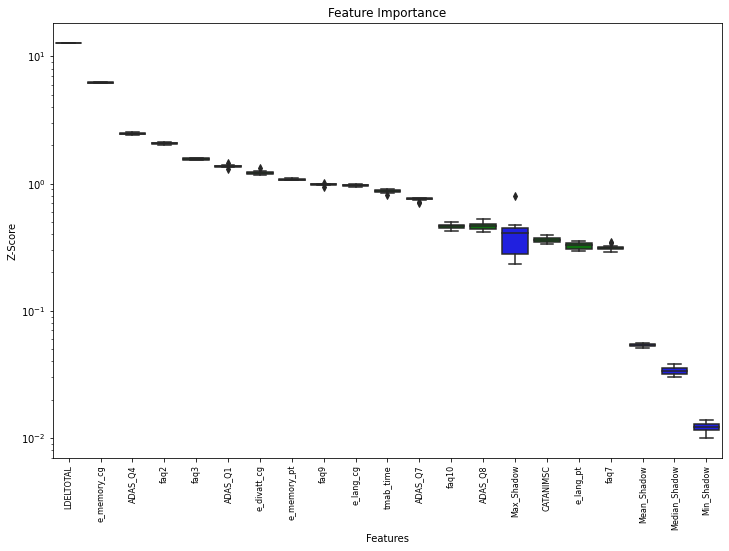

In [6]:
bshap.plot(which_features='accepted')

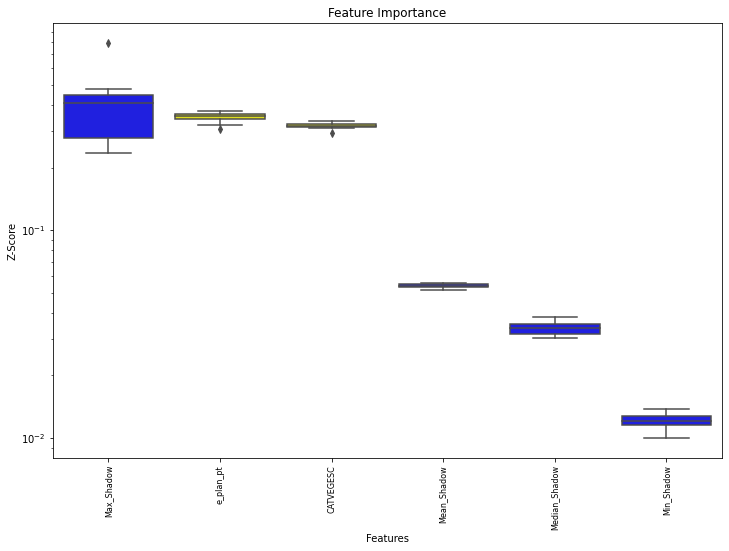

In [7]:
bshap.plot(which_features='tentative')

## Boruta FS

In [7]:
from boruta import BorutaPy


bp = BorutaPy(rf, n_estimators='auto', random_state=33433, verbose=0)
bp.fit(X.values, y)

features_ = list(np.array(features)[bp.support_])
features_weak = list(np.array(features)[bp.support_weak_])

print(features_)
print(features_weak)

['ADAS_Q1', 'ADAS_Q7', 'ADAS_Q4', 'LDELTOTAL', 'tmab_time', 'faq2', 'faq3', 'e_memory_pt', 'e_memory_cg', 'e_divatt_cg']
['ADAS_Q8', 'CATANIMSC']


In [8]:
from boruta import BorutaPy

bp = BorutaPy(rf, n_estimators='auto', random_state=33433, verbose=0, perc=85)
bp.fit(X.values, y)

features_ = list(np.array(features)[bp.support_])
features_weak = list(np.array(features)[bp.support_weak_])

print(features_)
print(features_weak)

['ADAS_Q1', 'ADAS_Q7', 'ADAS_Q8', 'nbspan_forward', 'ADAS_Q4', 'LDELTOTAL', 'AVDEL30MIN', 'faq9', 'tmab_time', 'ADAS_Q11', 'CATANIMSC', 'CATVEGESC', 'faq2', 'faq3', 'faq4', 'faq10', 'e_memory_pt', 'e_lang_pt', 'e_plan_pt', 'e_memory_cg', 'e_lang_cg', 'e_divatt_cg']
['MMCITY']


In [9]:
from boruta import BorutaPy

bp = BorutaPy(rf, n_estimators='auto', random_state=33433, verbose=0, perc=70)
bp.fit(X.values, y)

features_ = list(np.array(features)[bp.support_])
features_weak = list(np.array(features)[bp.support_weak_])

print(features_)
print(features_weak)

['ADAS_Q1', 'ADAS_Q7', 'ADAS_Q8', 'MMDATE', 'nbspan_forward', 'faq7', 'moca_recall', 'ADAS_Q4', 'MMTREEDL', 'LDELTOTAL', 'AVRECALL', 'AVDEL30MIN', 'AVDELTOT', 'faq9', 'tmab_time', 'TRABERRCOM', 'TRABERROM', 'moca_repeat', 'ADAS_Q11', 'CATANIMSC', 'CATVEGESC', 'ADAS_Q13', 'nbspan_backward', 'faq2', 'faq3', 'faq4', 'faq6', 'faq10', 'e_memory_pt', 'e_lang_pt', 'e_plan_pt', 'e_divatt_pt', 'e_memory_cg', 'e_lang_cg', 'e_organ_cg', 'e_divatt_cg']
['MMCITY']


## RFE

In [10]:
from sklearn.feature_selection import RFE

selector = RFE(rf, n_features_to_select=15, step=1, verbose=1)
selector = selector.fit(X, y)
features_ = list(np.array(features)[selector.support_])
print(features_)

Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator wi